In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.metrics import r2_score

In [79]:
# Load Metadata
df1 = pd.read_csv(r"data/survey_data/delskv-1994-2014.csv",  header=[0], index_col = 0)
meta_df = df1[['floor_area', 'wall_material','total_adults', 'total_children','monthly_income','water_access','roof_material','years_electrified']] # Select relevant features
meta_df['total_residents'] = meta_df['total_adults'] + meta_df['total_children'] # Create total_residents feature

# Load gauss fit data
data = pd.read_pickle('sorted_households.pkl') # Read pickle file
# Read in only the sorted households, combine the dataframes with the sorted households features, perform clustering!!
# Include the other finished bins that completed feature extraction

df_50_150 = pd.read_csv(r'data/features/FitFeatures/FitFeatures_50_150.csv',  header=[0, 1], index_col = 0)
df_150_400 = pd.read_csv(r'data/features/FitFeatures/FitFeatures_150_400.csv',  header=[0, 1], index_col = 0)
df_400_600 = pd.read_csv(r'data/features/FitFeatures/FitFeatures_400_600.csv',  header=[0, 1], index_col = 0)
df_600_1200 = pd.read_csv('data/features/FitFeatures/FitFeatures_600_1200.csv',  header=[0, 1], index_col = 0)
df_1200_2500 = pd.read_csv(r'data/features/FitFeatures/FitFeatures_1200_2500.csv',  header=[0, 1], index_col = 0)
df_2500_4000 = pd.read_csv(r'data/features/FitFeatures/FitFeatures_2500_4000.csv',  header=[0, 1], index_col = 0)

# Select all filtered households 
df_50_150.loc[data['50_150']] 
df_150_400.loc[data['150_400']]
df_400_600.loc[data['400_600']] 
df_600_1200.loc[data['600_1200']] 
df_1200_2500.loc[data['1200_2500']] 

# Combine all the data
frame = [df_150_400,df_400_600,df_1200_2500,df_2500_4000]

df2 = pd.DataFrame()
df2 = df_50_150.append(frame)

<ipython-input-79-e8e4f7234d3b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_df['total_residents'] = meta_df['total_adults'] + meta_df['total_children'] # Create total_residents feature


### Remove outliers in Gauss_fit dataframe

In [81]:
# Remove outliers

# Find absolute value of z-score for each observation
z = np.abs(stats.zscore(df2))

# #only keep rows in dataframe with all z-scores less than absolute value of 3 
df2 = df2[(z<3).all(axis=1)]

In [82]:
# Drop all NaN values from dataframe
meta_df = meta_df.dropna()

# Filter out only households with Gauss Fit that completed a survey
households_ids1 = df2.index.to_list()
meta_df_filtered = meta_df.loc[meta_df.index.isin(households_ids1),:]

# Filter out only households that completed a survey from Gauss Fit
households_ids2 = meta_df_filtered.index.to_list()
df2_filtered = df2.loc[df2.index.isin(households_ids2),:]

# Perform Linear Regression

### On all points

R2 = -1.394499292587307


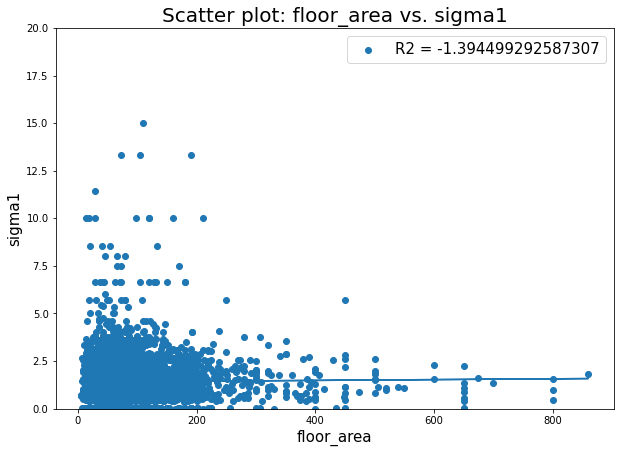

In [94]:
x = meta_df_filtered.iloc[:,0]
y = df2_filtered['Morning'].iloc[:,0]

r2 = r2_score(x, y)
print(f"R2 = {r2}")

x_label = meta_df_filtered.columns[0]
y_label = df2_filtered['Morning'].columns[0]

slope, intercept, r, p, std_err = stats.linregress(x, y)

def myfunc(x):
  return slope * x + intercept

mymodel = list(map(myfunc, x))

fig, ax = plt.subplots(figsize =(10, 7))


plt.scatter(x, y, label = "R2 = " + str(r2))
plt.plot(x, mymodel)
plt.rc('axes', titlesize=20) 
plt.rc('axes', labelsize=15)
plt.title("Scatter plot: " + x_label + " vs. " + y_label)
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.set_ylim(0,20)
plt.legend(prop = {'size':15})
# ax.set_yscale(scale)
# ax.set_xscale(scale)
plt.show()



### On median points

In [123]:
# Create binned dataset
df = pd.DataFrame()
df = pd.merge(df2_filtered['Morning'], meta_df_filtered, left_index=True, right_index=True)


bins = np.arange(0,1000,100)

df['bins'] = pd.cut(df.floor_area, bins=bins,  right=False, include_lowest=True)

sigma1_median = df.groupby(['bins'])['sigma1'].median() # Calculate median sigma value for each bin
sigma_1_DF = sigma1_median.to_frame() 
sigma_1_DF['bins'] = np.arange(0,900,100)

ValueError: Expected 2D array, got 1D array instead:
array=[1.25       1.23076923 1.12412795 1.28008193 1.02564103 1.42857143
 1.13207547 1.17647059 1.1010101 ].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

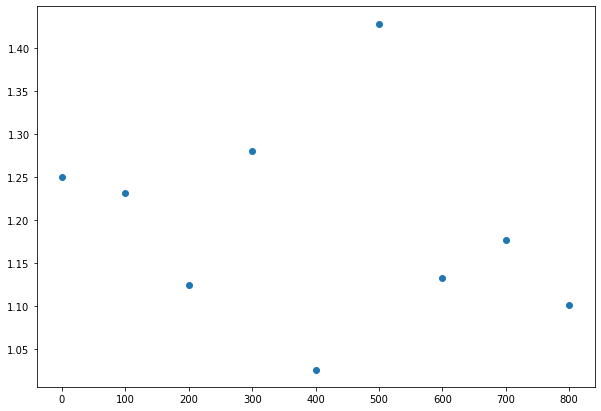

In [241]:
from sklearn.linear_model import LinearRegression
# import statsmodels.api as sm

# fit regression model
model = LinearRegression()
y, X = sigma_1_DF['sigma1'], sigma_1_DF['bins']

X = np.array(X.values.tolist())
y = np.array(y.values.tolist())

X = X.reshape(-1,1)

model.fit(X, y) # Linear Regression model

#display adjusted R-squared
r2 = 1 - (1-model.score(X, y))*(len(y)-1)/(len(y)-X.shape[1]-1)

# x = sigma_1_DF['bins']
# y = sigma_1_DF['sigma1']

x_label = meta_df_filtered.columns[0]
y_label = df2_filtered['Morning'].columns[0]

fig, ax = plt.subplots(figsize =(10, 7))

plt.scatter(x, y, label = "R-squared = " + str('{0:.3g}'.format(r2)))
plt.plot(x, model.predict(y).reshape(-1,1))
plt.rc('axes', titlesize=20) 
plt.rc('axes', labelsize=15)
plt.title("Scatter plot: " + x_label + " vs. " + y_label)
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.set_ylim(0,2)
plt.legend(prop = {'size':15})
# ax.set_yscale(scale)
# ax.set_xscale(scale)
plt.show()

In [174]:
sigma_1_DF

,sigma1,bins
bins,,
"[0, 100)",1.250000,0
"[100, 200)",1.230769,100
"[200, 300)",1.124128,200
"[300, 400)",1.280082,300
"[400, 500)",1.025641,400
"[500, 600)",1.428571,500
"[600, 700)",1.132075,600
"[700, 800)",1.176471,700
"[800, 900)",1.101010,800


ProfileID
121         (19121.866, 263364.78]
123          (10227.27, 19121.866]
126            (4545.45, 6604.788]
130            (4545.45, 6604.788]
132             (2512.56, 3316.33]
                     ...          
12029006      (6604.788, 10227.27]
12029010          (-0.001, 714.29]
12029019         (714.29, 1398.81]
12029032         (714.29, 1398.81]
12029036       (4545.45, 6604.788]
Name: monthly_income, Length: 5125, dtype: category
Categories (10, interval[float64]): [(-0.001, 714.29] < (714.29, 1398.81] < (1398.81, 1819.966] < (1819.966, 2512.56] ... (4545.45, 6604.788] < (6604.788, 10227.27] < (10227.27, 19121.866] < (19121.866, 263364.78]]

In [223]:
temp = meta_df_filtered.loc[~(meta_df_filtered['monthly_income'] == 0.0)] # filter out all households with R0 monthly income, Treat as incorrectly filled in questionaire

temp_df = pd.merge(meta_df_filtered['monthly_income'], df2['Morning']['sigma1'], left_index=True, right_index=True)

In [225]:
# # Bin the data frame by "a" with 10 bins...
# bins = np.linspace(temp_df.monthly_income.min(), temp_df.monthly_income.max(), 10)
# groups = temp_df.groupby(np.digitize(temp_df.monthly_income, bins))

# # Get the mean of each bin:
# print(groups.mean().sigma1) # Also could do "groups.aggregate(np.mean)"

# # Similarly, the median:
# print(groups.median().sigma1)

# # # Apply some arbitrary function to aggregate binned data
# # print(groups.aggregate(lambda x: np.mean(x[x > 0.5])))

In [226]:
bins

array([     0.        ,  29262.75333333,  58525.50666667,  87788.26      ,
       117051.01333333, 146313.76666667, 175576.52      , 204839.27333333,
       234102.02666667, 263364.78      ])

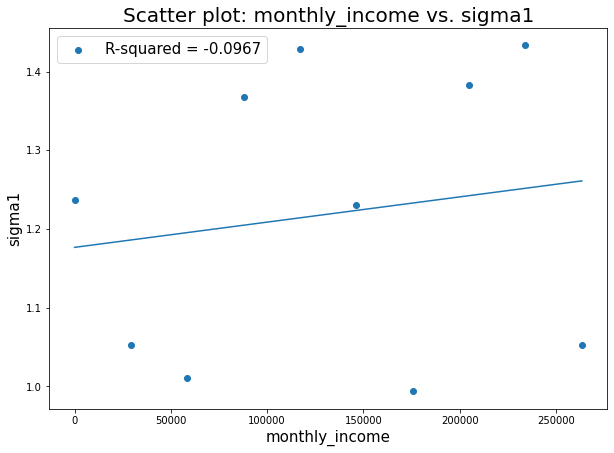

Morning


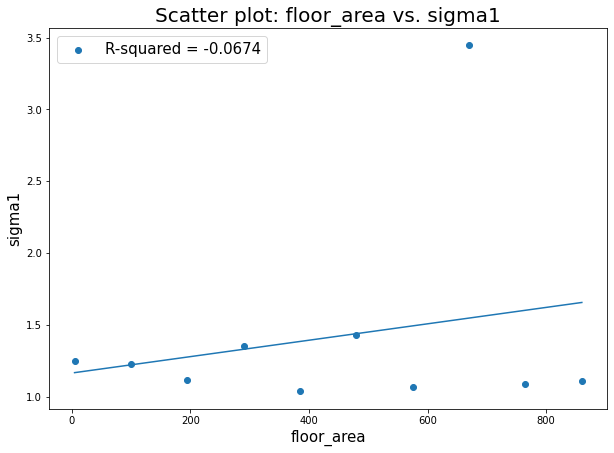

Morning


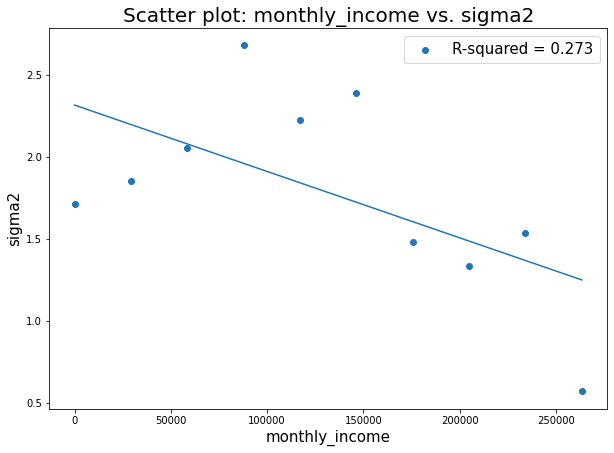

Morning


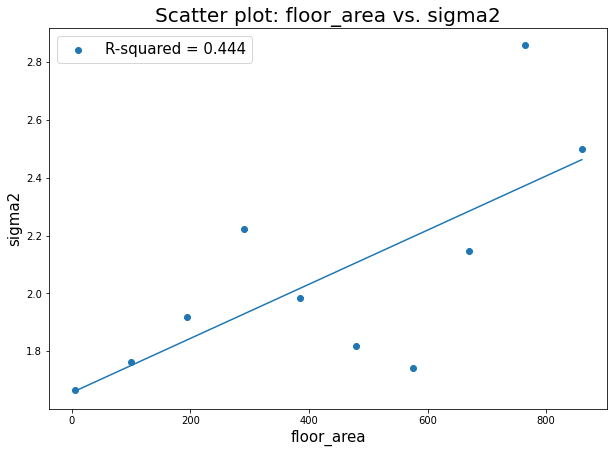

Morning


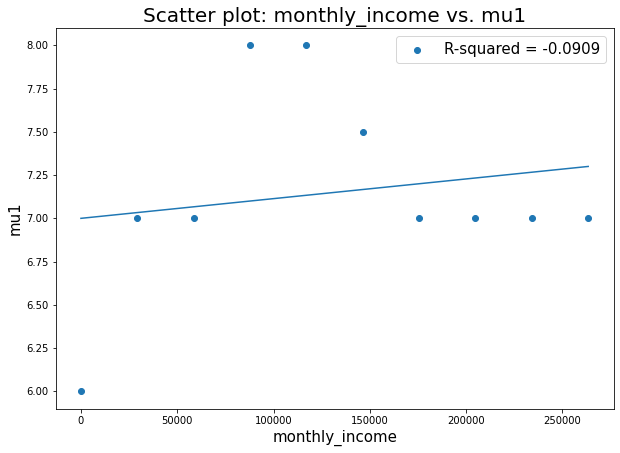

Morning


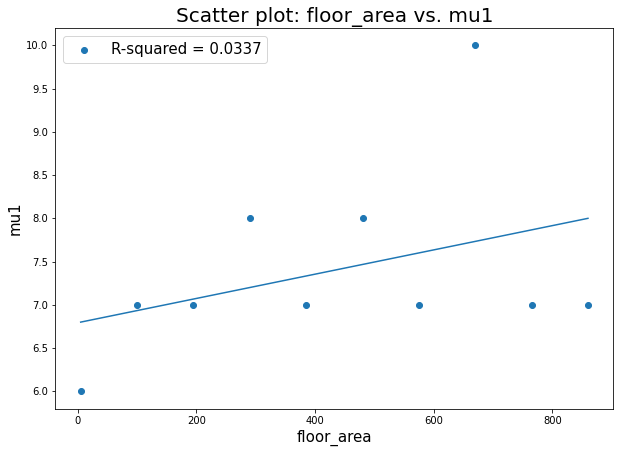

Morning


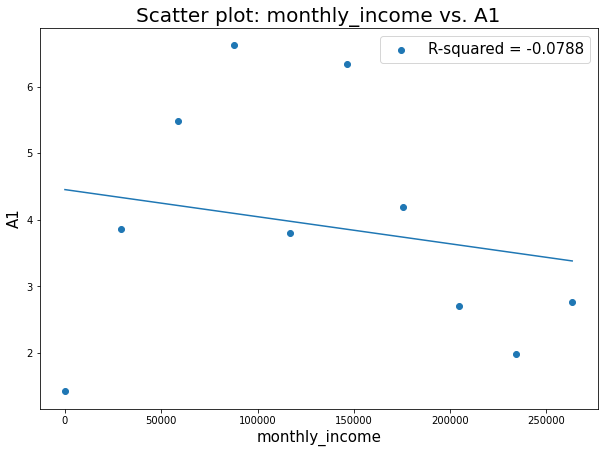

Morning


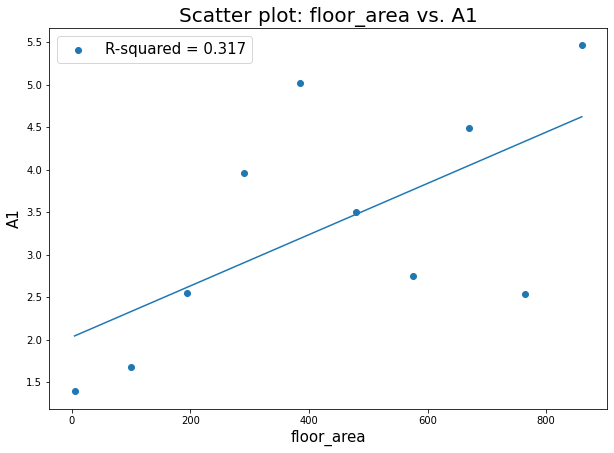

Morning


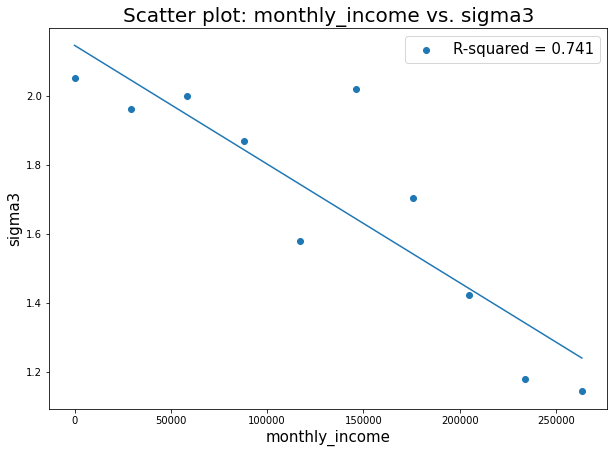

Afternoon


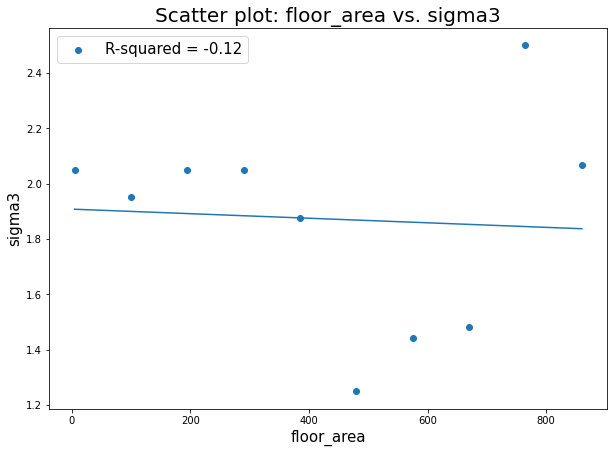

Afternoon


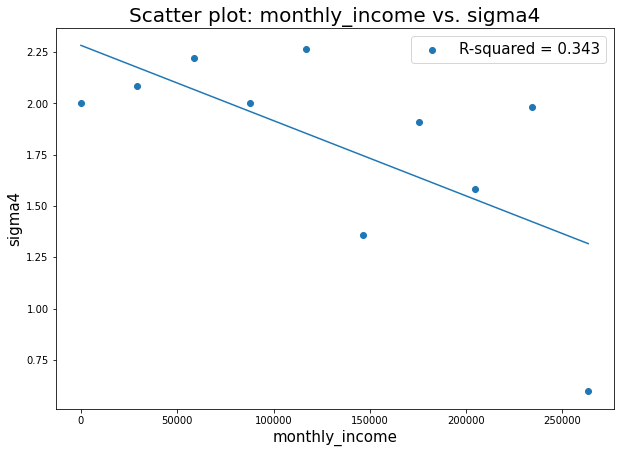

Afternoon


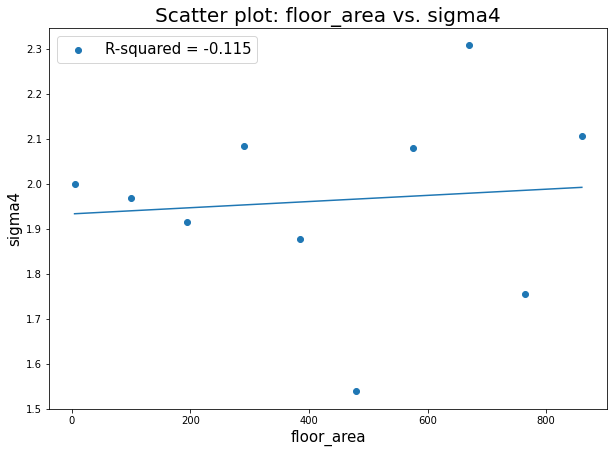

Afternoon


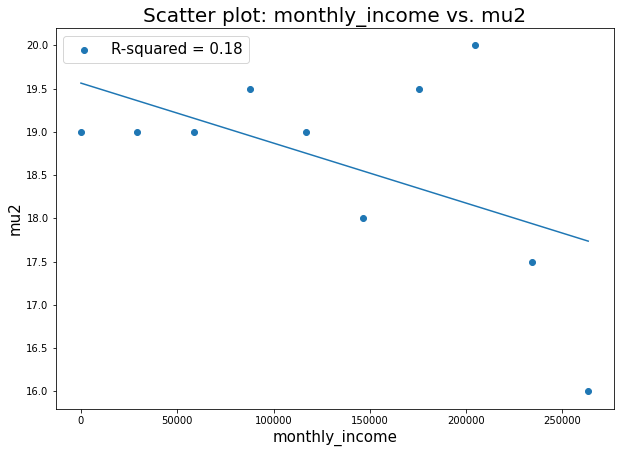

Afternoon


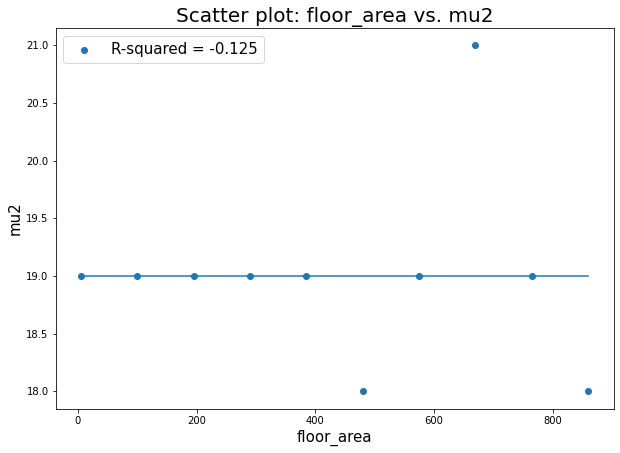

Afternoon


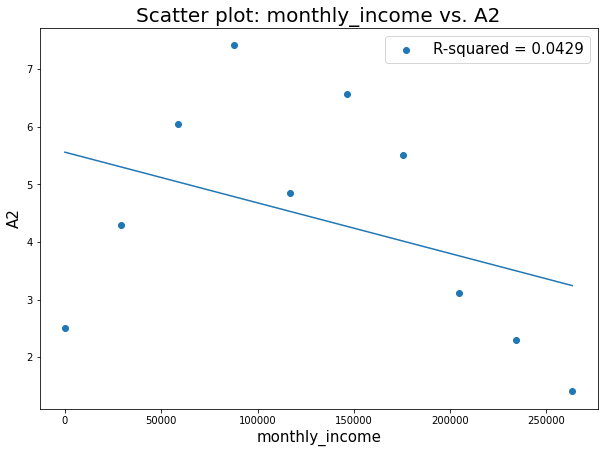

Afternoon


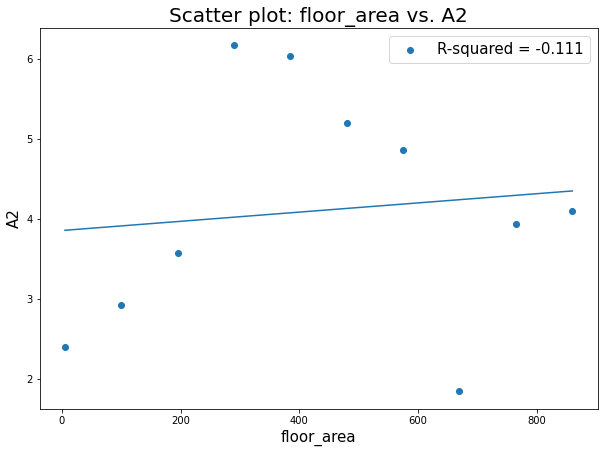

Afternoon


In [268]:
column_string = ['monthly_income', 'floor_area']

for day,j in df2_filtered:

    for column in column_string:
    
        temp_df = pd.merge(meta_df_filtered[column], df2[day][j], left_index=True, right_index=True)

        # temp_df = pd.merge(meta_df_filtered['monthly_income'], df2[day][j], left_index=True, right_index=True)

        # Bin the data frame by "a" with 10 bins...
        bins = np.linspace(temp_df[column].min(), temp_df[column].max(), 10)
        groups = temp_df.groupby(np.digitize(temp_df[column], bins))
        
        # fit regression model
        model = LinearRegression()
        # y, X = sigma_1_DF['sigma1'], sigma_1_DF['bins']

        # X = np.array(X.values.tolist())
        # y = np.array(y.values.tolist())
        y = groups.median()[j]
        X = bins

        X = X.reshape(-1,1)

        model.fit(X, y) # Linear Regression model

        #display adjusted R-squared
        r2 = 1 - (1-model.score(X, y))*(len(y)-1)/(len(y)-X.shape[1]-1)

        x_label = temp_df.columns[0]
        y_label = temp_df.columns[1]

        fig, ax = plt.subplots(figsize =(10, 7))

        plt.scatter(X, y, label = "R-squared = " + str('{0:.3g}'.format(r2)))
        plt.plot(X, model.predict(X))
        plt.rc('axes', titlesize=20) 
        plt.rc('axes', labelsize=15)
        plt.title("Scatter plot: " + x_label + " vs. " + y_label)
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        # ax.set_ylim(0,2)
        plt.legend(prop = {'size':15})
        # ax.set_yscale(scale)
        # ax.set_xscale(scale)
        plt.show()


        print(day)

        # Morning
        # # Save the figure
        # fig.savefig("/thesis_project/Figures/regression/" + day + "/" +j +"vs" + column + ".png", bbox_inches='tight')
        fig.savefig(day + "_" +j +"vs" + column + ".png", bbox_inches='tight')

In [254]:
meta_df_filtered

,floor_area,wall_material,total_adults,total_children,monthly_income,water_access,roof_material,years_electrified,total_residents
ProfileID,,,,,,,,,
121,50.0,Brick,5,2,23396.23,tap inside house,Asbestos,10.0,7
123,50.0,Brick,3,5,12452.83,tap inside house,Asbestos,10.0,8
126,50.0,Brick,3,1,5283.02,tap inside house,Asbestos,10.0,4
130,50.0,Brick,3,2,5660.38,tap inside house,Asbestos,10.0,5
132,50.0,Brick,3,3,3207.55,tap inside house,Asbestos,10.0,6
...,...,...,...,...,...,...,...,...,...
12029006,61.0,Plaster,3,1,9659.09,tap in yard,IBR/Corr.Iron/Zinc,2.0,4
12029010,59.0,Plaster,1,0,227.27,tap in yard,IBR/Corr.Iron/Zinc,30.0,1
12029019,132.0,Plaster,2,0,1022.73,tap inside house,IBR/Corr.Iron/Zinc,30.0,2
